# Exploring Ensemble Methods

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in GraphLab Create. You will:

* Use SFrames to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

Let's get started!

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import GradientBoostingClassifier

# Load LendingClub dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. As discussed earlier, the [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. 

Just like we did in previous assignments, we will build a classification model to predict whether or not a loan provided by lending club is likely to default.

Let us start by loading the data.

In [4]:
%%capture
loans = pd.read_csv('./data/lending-club-data.csv')
loans.term = loans.term.apply(str.strip)

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset. Here, we should see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc.

In [5]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122607 entries, 0 to 122606
Data columns (total 68 columns):
id                             122607 non-null int64
member_id                      122607 non-null int64
loan_amnt                      122607 non-null int64
funded_amnt                    122607 non-null int64
funded_amnt_inv                122607 non-null int64
term                           122607 non-null object
int_rate                       122607 non-null float64
installment                    122607 non-null float64
grade                          122607 non-null object
sub_grade                      122607 non-null object
emp_title                      115767 non-null object
emp_length                     118516 non-null object
home_ownership                 122607 non-null object
annual_inc                     122603 non-null float64
is_inc_v                       122607 non-null object
issue_d                        122607 non-null object
loan_status                

## Modifying the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column 1 means a risky (bad) loan 0 means a safe  loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [6]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.drop(['bad_loans'], axis=1, inplace=True)

## Selecting features

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

The features we will be using are described in the code comments below:

In [7]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

Recall from the lectures that one common approach to coping with missing values is to **skip** observations that contain missing values.

We run the following code to do so:

In [8]:
print(loans.shape[0])
loans = pd.get_dummies(loans[[target] + features].dropna())
print(loans.shape[0])

122607
122578


In [9]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122578 entries, 0 to 122606
Data columns (total 45 columns):
safe_loans                    122578 non-null int64
sub_grade_num                 122578 non-null float64
short_emp                     122578 non-null int64
emp_length_num                122578 non-null int64
dti                           122578 non-null float64
payment_inc_ratio             122578 non-null float64
delinq_2yrs                   122578 non-null float64
delinq_2yrs_zero              122578 non-null float64
inq_last_6mths                122578 non-null float64
last_delinq_none              122578 non-null int64
last_major_derog_none         122578 non-null int64
open_acc                      122578 non-null float64
pub_rec                       122578 non-null float64
pub_rec_zero                  122578 non-null float64
revol_util                    122578 non-null float64
total_rec_late_fee            122578 non-null float64
int_rate                      12257

Fortunately, there are not too many missing values. We are retaining most of the data.

## Make sure the classes are balanced

follow the following steps:

- Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding. Alternatively, see #7 for implementation hints.
- Load the JSON files into the lists train_idx and validation_idx.
- Perform train/validation split using train_idx and validation_idx.

In [10]:
train_idx = pd.read_json('./data/module-8-assignment-1-train-idx.json', typ='series').tolist()
validation_idx = pd.read_json('./data/module-8-assignment-1-validation-idx.json', typ='series').tolist()

In [11]:
train_data = loans.iloc[train_idx].copy()
validation_data = loans.iloc[validation_idx].copy()

Note: Some elements in loans are included neither in train_data nor validation_data. This is to perform sampling to achieve class balance.

**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

# Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

**Additional reading:** If you are interested in gradient boosted trees, here is some additional reading material:
* [GraphLab Create user guide](https://dato.com/learn/userguide/supervised-learning/boosted_trees_classifier.html)
* [Advanced material on boosted trees](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)


We will now train models to predict `safe_loans` using the features above. In this section, we will experiment with training an ensemble of 5 trees.

Now, let's use the built-in scikit learn gradient boosting classifier ([sklearn.ensemble.GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)) to create a gradient boosted classifier on the training data. You will need to import sklearn, sklearn.ensemble, and numpy.

You will have to first convert the SFrame into a numpy data matrix. You will also have to extract the label column. Make sure to set max_depth=6 and n_estimators=5.

In [12]:
X_Tr = train_data.loc[:,train_data.columns!='safe_loans'].values
y_Tr = train_data.safe_loans.values
X_Va = validation_data.loc[:,validation_data.columns!='safe_loans'].values
y_Va = validation_data.safe_loans.values

In [13]:
model_5 = GradientBoostingClassifier(max_depth=6, n_estimators=5).fit(X_Tr, y_Tr)

# Making predictions

Just like we did in previous sections, let us consider a few positive and negative examples **from the validation set**. We will do the following:
* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

In [14]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
X_Va_sample = sample_validation_data.loc[:,sample_validation_data.columns!='safe_loans'].values

### Predicting on sample validation data

For each row in the **sample_validation_data**, write code to make **model_5** predict whether or not the loan is classified as a **safe loan**.

**Hint:** Use the `predict` method in `model_5` for this.

In [15]:
model_5.predict(X_Va_sample)

array([ 1,  1, -1,  1], dtype=int64)

In [16]:
sample_validation_data.safe_loans.values

array([ 1,  1, -1, -1], dtype=int64)

### Prediction probabilities

For each row in the **sample_validation_data**, what is the probability (according **model_5**) of a loan being classified as **safe**?

In [17]:
model_5.predict_proba(X_Va_sample)[:,1]

array([0.58357669, 0.53050311, 0.46192208, 0.60408361])

**Checkpoint:** Can you verify that for all the predictions with `probability >= 0.5`, the model predicted the label **+1**?

## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **model_5** on the **validation_data**.

**Hint**: Hint: if you are using scikit-learn, you can use the [.score()](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.score) method

In [18]:
model_5.score(X_Va, y_Va)

0.6613528651443343

Calculate the number of **false positives** made by the model.

In [19]:
FP = np.sum((y_Va == -1) & (model_5.predict(X_Va) == +1))
FP

1653

Calculate the number of **false negatives** made by the model.

In [20]:
FN = np.sum((y_Va == +1) & (model_5.predict(X_Va) == -1))
FN

1491

## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around **0.64** (rounded). In this assignment, we saw that **model_5** has an accuracy of **0.67** (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost of the mistakes of the model is 49.42M. That is a **lot of money**!.

Calculate the cost of mistakes made by model_5 on the validation_data.

In [21]:
'{:,}'.format(FN * 1e4 + FP * 2e4)

'47,970,000.0'

**Reminder**: Compare the cost of the mistakes made by the boosted trees model with the decision tree model. The extra 3% improvement in prediction accuracy can translate to several million dollars!  And, it was so easy to get by simply boosting our decision trees.

## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

Start here with **Step 1** & **Step 2**. Make predictions using **model_5** for examples in the **validation_data**. Use `output_type = probability`.

In [22]:
validation_data['predictions'] = model_5.predict_proba(X_Va)[:,1]

**Checkpoint:** For each row, the probabilities should be a number in the range **[0, 1]**. We have provided a simple check here to make sure your answers are correct.

In [23]:
print("    Your answer : %s" % validation_data['predictions'].head(4).values)
print("Expected answer : %s" % [0.4492515948736132, 0.6119100103640573,
                                0.3835981314851436, 0.3693306705994325])

    Your answer : [0.46192208 0.60408361 0.47987242 0.40692385]
Expected answer : [0.4492515948736132, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]


Now, we are ready to go to **Step 3**. You can now use the `prediction` column to sort the loans in **validation_data** (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a **safe loan**.

In [24]:
validation_data.sort_values(by='predictions', inplace=True, ascending=False)
validation_data.head(5).loc[:,'grade_A':'grade_G']

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
8021,1,0,0,0,0,0,0
16736,1,0,0,0,0,0,0
67183,1,0,0,0,0,0,0
27214,1,0,0,0,0,0,0
73426,1,0,0,0,0,0,0


Let us repeat this excercise to find the top 5 loans (in the **validation_data**) with the **lowest probability** of being predicted as a **safe loan**:

In [25]:
validation_data.tail(5).loc[:,'grade_A':'grade_G']

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
114781,0,0,0,1,0,0,0
101746,0,0,0,1,0,0,0
27502,0,0,1,0,0,0,0
58794,0,0,1,0,0,0,0
84508,0,0,1,0,0,0,0


## Effect of adding more trees

In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees.

Train models with 10, 50, 100, 200, and 500 trees. Use the n_estimators parameter to control the number of trees. Remember to keep max_depth = 6.

Call these models model_10, model_50, model_100, model_200, and model_500, respectively. This may take a few minutes to run.

**Warning:** This could take a couple of minutes to run.

In [26]:
model_10 = GradientBoostingClassifier(max_depth=6, n_estimators=10).fit(X_Tr, y_Tr)
model_50 = GradientBoostingClassifier(max_depth=6, n_estimators=50).fit(X_Tr, y_Tr)
model_100 = GradientBoostingClassifier(max_depth=6, n_estimators=100).fit(X_Tr, y_Tr)
model_200 = GradientBoostingClassifier(max_depth=6, n_estimators=200).fit(X_Tr, y_Tr)
model_500 = GradientBoostingClassifier(max_depth=6, n_estimators=500).fit(X_Tr, y_Tr)

## Compare accuracy on entire validation set

Now we will compare the predicitve accuracy of our models on the validation set. Evaluate the **accuracy** of the 10, 50, 100, 200, and 500 tree models on the **validation_data**.

In [27]:
print('  5 Trees: %.4f' % model_5.score(X_Va, y_Va))
print(' 10 Trees: %.4f' % model_10.score(X_Va, y_Va))
print(' 50 Trees: %.4f' % model_50.score(X_Va, y_Va))
print('100 Trees: %.4f' % model_100.score(X_Va, y_Va))
print('200 Trees: %.4f' % model_200.score(X_Va, y_Va))
print('500 Trees: %.4f' % model_500.score(X_Va, y_Va))

  5 Trees: 0.6614
 10 Trees: 0.6654
 50 Trees: 0.6846
100 Trees: 0.6882
200 Trees: 0.6861
500 Trees: 0.6895


## Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. You will need [matplotlib](http://matplotlib.org/downloads.html) in order to visualize the plots. 

First, make sure this block of code runs on your computer.

In [28]:
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `.evaluate`. 

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [29]:
train_err_10 = 1 - model_10.score(X_Tr, y_Tr)
train_err_50 = 1 - model_50.score(X_Tr, y_Tr)
train_err_100 = 1 - model_100.score(X_Tr, y_Tr)
train_err_200 = 1 - model_200.score(X_Tr, y_Tr)
train_err_500 = 1 - model_500.score(X_Tr, y_Tr)

Now, let us run **Step 2**. Save the training errors into a list called **training_errors**

In [30]:
training_errors = [train_err_10, train_err_50, train_err_100, 
                   train_err_200, train_err_500]

Now, onto **Step 3**. Write code to compute the classification error on the **validation_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [31]:
validation_err_10 = 1 - model_10.score(X_Va, y_Va)
validation_err_50 = 1 - model_50.score(X_Va, y_Va)
validation_err_100 = 1 - model_100.score(X_Va, y_Va)
validation_err_200 = 1 - model_200.score(X_Va, y_Va)
validation_err_500 = 1 - model_500.score(X_Va, y_Va)

Now, let us run **Step 4**. Save the training errors into a list called **validation_errors**

In [32]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, 
                     validation_err_200, validation_err_500]

Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook. 

Run the following code to visualize the plots.

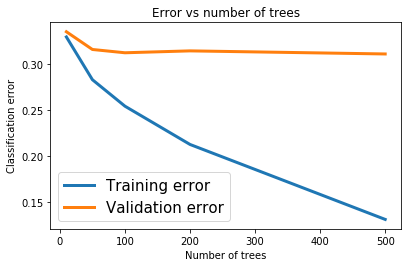

In [33]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=3.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=3.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')